In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path

import sys
sys.path.insert(0, '../completenessContours')
import compute_num_completeness_w_ve_insol as kp

sys.path.insert(0, '..')
import occRateUtils as ut

import rateModels3D as rm3D

In [2]:
stellarType = "hab2"
catalog = "dr25"

if stellarType == "hab":
    teffRange = (4800, 6300)
elif stellarType == "hab2":
    teffRange = (3900, 6300)
elif stellarType == "GK":
    teffRange = (3900, 6000)
elif stellarType == "FGK":
    teffRange = (3900, 7300)
else:
    raise ValueError('Bad catalog name');
    
cs = rm3D.compSpace(periodName = "Instellation", 
               periodUnits = "$I_\oplus$",
               periodRange = (0.2, 2.2), 
               nPeriod = 61,
               radiusName = "Radius", 
               radiusUnits = "$R_\oplus$",
               rpRange = (0.5, 2.5), 
               nRp = 61,
               tempName = "$T_\mathrm{eff}$", 
               tempUnits = "K",
               tempRange = teffRange, 
               nTemp = 10)

# model 1: triplePowerLawTeffAvg
# model 2: triplePowerLaw
# model 3: dualPowerLawFixedTeffAvg
# model 4: dualPowerLaw
# model 5: constantFixedTeffAvg
model = rm3D.triplePowerLawTeffAvg(cs)

# completenessExtrapType = "extrap_const"
completenessExtrapType = "extrap_zero"

# make output directory if needed
# outDir = "computeOccurrencefixedTeff_" + catalog + "_" + stellarType + "_"  \
#         + model.name + "_" + completenessExtrapType + "_uncertainty_out"
# outDir = "computeOccurrencefixedTeff_" + catalog + "_" + stellarType + "_"  \
#         + model.name + "_" + completenessExtrapType + "_zero500_uncertainty_out"
outDir = "computeOccurrencefixedTeff_" + catalog + "_" + stellarType + "_"  \
        + model.name + "_" + completenessExtrapType + "_zero400_uncertainty_out"
if not path.exists(outDir):
    os.mkdir(outDir)



In [3]:
# population inference functions

def lnlike(theta, cs, koi_periods, koi_rps, koi_teffs, sumComp, teffMeans, model):
    norm = 0
#     dT = (cs.tempRange[1]-cs.tempRange[0])/cs.nTemp
#     dT = (cs.tempRange[1]-cs.tempRange[0])
#     teffArray = np.linspace(cs.tempRange[0], cs.tempRange[1], cs.nTemp+1)
    for i in range(cs.nTemp):
        m = model.rateModel(cs.period2D, cs.rp2D, teffMeans[i], cs.periodRange, cs.rpRange, cs.tempRange, theta)
#         m = model.integrateZ(cs.period2D, cs.rp2D, [teffArray[i], teffArray[i+1]], theta, cs)
        pop = m*sumComp[:,:,i]
        pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
        norm = norm + np.sum(pop * cs.vol2D)
    ll = np.sum(np.log(model.rateModel(koi_periods, koi_rps, koi_teffs, cs.periodRange, cs.rpRange, cs.tempRange, theta))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just propotional to the ln-likelihood
# since we're assuming uniform priors.
def lnprob(theta, cs, koi_periods, koi_rps, koi_teffs, sumComp, teffMeans, model):
    lp = lnPoisprior(theta, model)
    if not np.isfinite(lp):
        return -np.inf

    return lnlike(theta, cs, koi_periods, koi_rps, koi_teffs, sumComp, teffMeans, model)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta, cs, koi_periods, koi_rps, koi_teffs, sumComp, teffMeans, model):
    ll = lnlike(theta, cs, koi_periods, koi_rps, koi_teffs, sumComp, teffMeans, model)
    return -ll if np.isfinite(ll) else 1e15

def lnPoisprior(theta, model):
    bounds = model.getBounds()
    inRange = True;
    for i in range(len(bounds)):
        if (bounds[i][0] > theta[i]) | (theta[i] >= bounds[i][1]):
            inRange = False
    
    if inRange:
        return 1.0
    return -np.inf


In [4]:
# stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2019_clean_GK.txt"
# pcCatalog = "../GKbaseline/koiCatalogs/dr25_GK_PCs.csv"
stellarCatalog = "../stellarCatalogs/dr25_stellar_berger2020_clean_" + stellarType + ".txt"
pcCatalog = "koiCatalogs/PCs_" + catalog + "_" + stellarType + ".csv"

innerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 0.75)
outerHZ = kp.earthflux_at_semia(1, 4.437, 5778.0, 1.77)
print("HZ flux: " + str(innerHZ) + " to " + str(outerHZ))

chz = rm3D.getHzFlux(np.linspace(3800, 6300, 6300-3800), hzType = "conservative")
ohz = rm3D.getHzFlux(np.linspace(3800, 6300, 6300-3800), hzType = "optimistic")

conservativeInnerHz = np.max(chz[0,:]);
conservativeOuterHz = np.min(chz[1,:]);

optimisticInnerHz = np.max(ohz[0,:]);
optimisticOuterHz = np.min(ohz[1,:]);


# for quick tests
nWalkers = 8
nBurnin = 2
nMcmc = 5000
# for production runs
# nWalkers = 16
# nBurnin = 1000
# nMcmc = 5000



HZ flux: 1.7777777777777777 to 0.3191930798940279


In [5]:
print(chz[0,:]-chz[1,:])
print(ohz[0,:]-ohz[1,:])

[0.68329105 0.68328925 0.68328748 ... 0.79100652 0.79108778 0.79116905]
[1.27741197 1.27743361 1.27745531 ... 1.54265958 1.54283259 1.54300561]


In [6]:
stellarTargets = pd.read_csv(stellarCatalog)

base_kois = pd.read_csv(pcCatalog)
base_kois = pd.merge(base_kois, stellarTargets[["kepid","logg"]], left_on="kepid_x", right_on="kepid", how="inner")

# base_kois["insolation"] = kp.earthflux_at_period(base_kois.radius, base_kois.logg, base_kois.teff, base_kois.koi_period)

m = (cs.periodRange[0] <= base_kois.insolation) & (base_kois.insolation <= cs.periodRange[1])
thisRadii = base_kois.gaia_iso_prad
m &= np.isfinite(thisRadii) & (cs.rpRange[0] <= thisRadii) & (thisRadii <= cs.rpRange[1])
# m &= base_kois.koi_period <= 500
m &= base_kois.koi_period <= 400

kois = pd.DataFrame(base_kois[m])
allKois = kois


In [7]:
m = (cs.periodRange[0] <= base_kois.insolation) & (base_kois.insolation <= cs.periodRange[1])
thisRadii = base_kois.gaia_iso_prad
m &= np.isfinite(thisRadii) & (cs.rpRange[0] <= thisRadii) & (thisRadii <= cs.rpRange[1])

origKois = pd.DataFrame(base_kois[m])

In [8]:
origKois[origKois.koi_period > 400]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use,totalReliability,Disp,kepid,logg
515,3548044,K02194.03,3,CANDIDATE,0.496,445.21685,7.933966,1.37,0.18,-0.18,...,445.217,0.0460,0.993425,0.981008,0.658151,0.0460,0.627876,PC,3548044,4.244097
1952,9650579,K07953.01,1,CANDIDATE,0.335,432.96905,7.316128,1.43,0.33,-0.12,...,432.969,0.2300,0.990432,0.980508,0.514042,0.2300,0.395812,PC,9650579,4.370274
1976,11714107,K08063.01,1,CANDIDATE,0.471,405.35457,8.280410,2.11,0.56,-0.24,...,405.355,0.0230,0.993545,0.976761,0.726945,0.0230,0.710225,PC,11714107,4.462703
2082,5802205,K08107.01,1,CANDIDATE,0.381,578.88761,7.586177,1.69,0.45,-0.67,...,578.888,0.0025,0.994990,0.984638,0.677288,0.0025,0.675595,PC,5802205,4.195906
2202,4446859,K08246.01,1,CANDIDATE,0.228,425.64971,7.156312,1.58,0.45,-0.37,...,425.650,0.0110,0.989097,0.980031,0.459003,0.0110,0.453954,PC,4446859,4.212769


(0.0, 2.5)

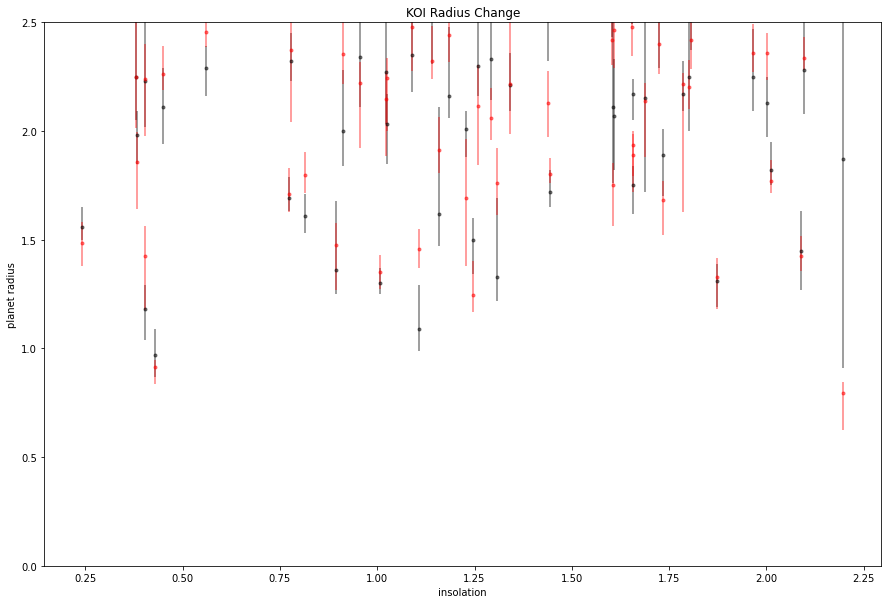

In [9]:
fig, ax = plt.subplots(figsize=(15,10));
ax.errorbar(kois.insolation, kois.koi_prad, 
            yerr = [-kois.koi_prad_err2, kois.koi_prad_err1],
            fmt="k.", alpha = 0.5);
ax.errorbar(kois.insolation, kois.gaia_iso_prad, 
            yerr = [kois.gaia_iso_prad_errm, kois.gaia_iso_prad_errp],
            fmt="r.", alpha = 0.5);

plt.xlabel("insolation");
plt.ylabel("planet radius");
plt.title("KOI Radius Change");
plt.ylim([0, 2.5])




In [10]:
(400-50)/31.25

11.2

In [11]:

from scipy import interpolate

if completenessExtrapType == "extrap_const": 
#     inputgrid = "../completenessContours/out_sc0_GK_baseline_insol_teff_extrap_const.fits.gz"
    inputgrid = "../completenessContours/out_sc0_" + stellarType + "_insol_teff_extrap_const.fits.gz"
elif completenessExtrapType == "extrap_zero":
#     inputgrid = "../completenessContours/out_sc0_GK_baseline_insol_teff.fits.gz"
    if catalog == "dr25":
        inputgrid = "../completenessContours/out_sc0_" + stellarType + "_insol_teff.fits.gz"
    else:
        inputgrid = "../completenessContours/out_sc0_" + stellarType + "_insol_teff_" + catalog + ".fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = cumulative_array[2]
probTeff = cumulative_array[3:,:,:]

cumulative_array[3:,:,:]
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
min_comp_flux = prihdr["MINFLX"]
max_comp_flux = prihdr["MAXFLX"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)

nTeff = prihdr["NTEFF"]
nstars = np.zeros(nTeff)
for i in range(nTeff):
    nstars[i] = prihdr["NSTEFF" + str(i)]
print(nstars)
meanTeff = np.zeros(nTeff)
for i in range(nTeff):
    meanTeff[i] = prihdr["MEANT" + str(i)]
print(meanTeff)

# period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
period_want = np.linspace(max_comp_flux, min_comp_flux, n_comp_period) 
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = interpolate.interp2d(period_want, rp_want, probtot);
summedCompleteness = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))

summedCompletenessTeff = np.zeros((cs.nPeriod, cs.nRp, nTeff))
for i in range(nTeff):
    numCompVeInterp = interpolate.interp2d(period_want, rp_want, probTeff[i,:,:])
    summedCompletenessTeff[:,:,i] = np.transpose(numCompVeInterp(cs.period1D, cs.rp1D))



[  912.  1598.  2131.  3308.  5013.  8008. 11330. 14287. 13188.  9110.]
[4031.31866721 4249.85126589 4502.5198096  4747.25744148 4992.24601188
 5228.41187379 5467.34321717 5704.24385745 5930.79351087 6174.69396553]


In [12]:
nTeff

10

In [13]:
summedCompletenessTeff.shape

(61, 61, 10)

In [14]:

min_comp_period


10.0

In [15]:
numCompVeInterp(cs.period1D, cs.rp1D).shape

(61, 61)

In [16]:
import matplotlib

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

light_BuGn = cmap_map(lambda x: x/2 + 0.5, plt.cm.get_cmap('GnBu'))


In [17]:
np.mean(kois.gaia_iso_insol_errm)

0.10464148087290043

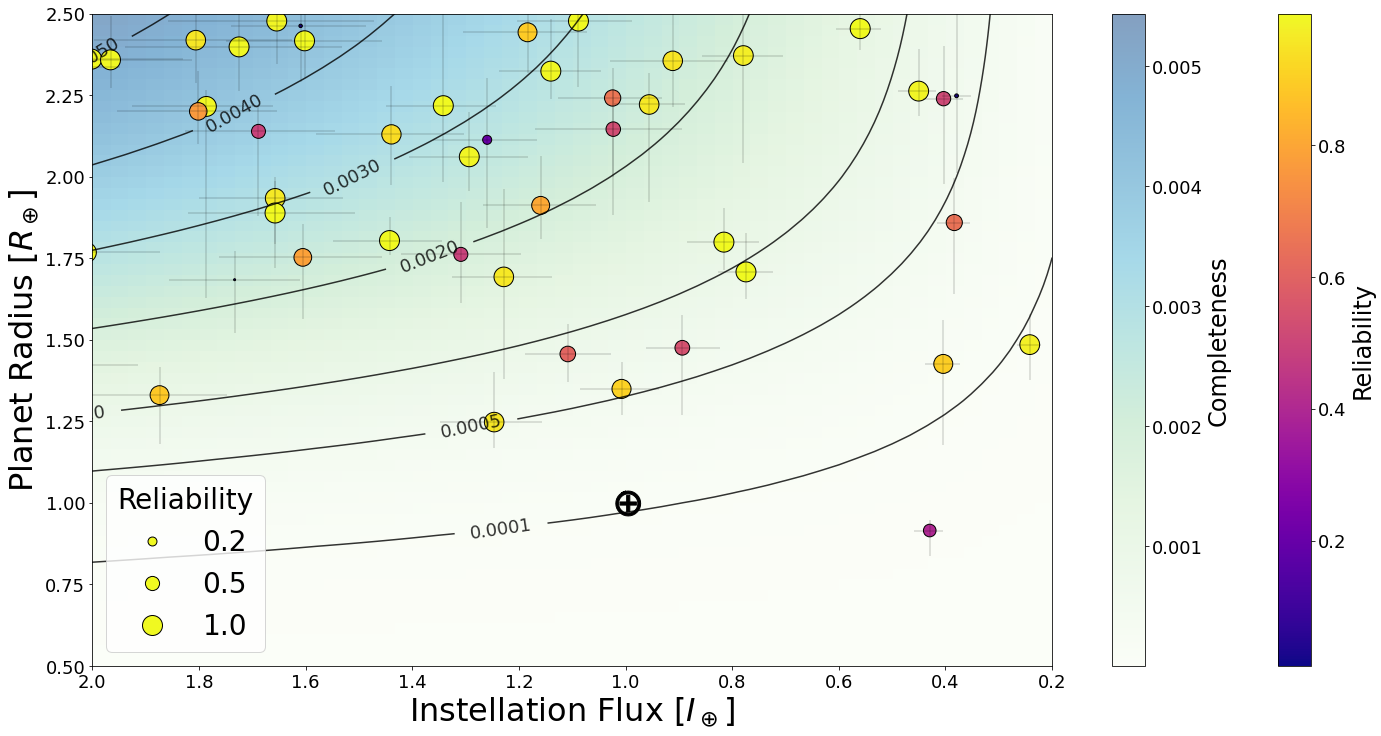

In [18]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(25,12));

pc = plt.pcolor(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, cmap=light_BuGn)
c = plt.contour(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(kois.insolation, kois.gaia_iso_prad, cmap="plasma", 
               c=kois.totalReliability, edgecolors='k', s=400*kois.totalReliability, alpha = 1.0)
ax.errorbar(kois.gaia_iso_insol, kois.gaia_iso_prad, 
            xerr = [kois.gaia_iso_insol_errm, kois.gaia_iso_insol_errp],
            yerr = [kois.gaia_iso_prad_errm, kois.gaia_iso_prad_errp],
            fmt="none", ecolor="k", alpha = 0.15, marker = None);

cbh = plt.colorbar(scf, pad=-0.01);
cbh.ax.set_ylabel("Reliability", fontsize = 24);
cbh.ax.tick_params(labelsize=18)

cbh = plt.colorbar(pc);
cbh.ax.set_ylabel("Completeness", fontsize = 24);
cbh.ax.tick_params(labelsize=18)

plt.scatter(1, 1, marker="$\oplus$", c='k', s=800, alpha = 1.0, zorder=100)

kw = dict(prop="sizes", num=[0.2, 0.5, np.max(kois.totalReliability)], 
          color=scf.cmap(1.0), fmt="{x:.1f}", 
          markeredgecolor='k', func=lambda s: s/400)
legend2 = plt.legend(*scf.legend_elements(**kw), loc="lower left", fontsize=28)
legend2.set_title("Reliability",prop={'size':28})


#c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
xlim = plt.xlim();
plt.xlim(xlim[1], xlim[0]);
# plt.xlim(50, 400)
plt.clabel(c, fontsize=18, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel('Instellation Flux [$I_\oplus$]', fontsize = 32);
plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 32);

# plt.plot([innerHZ, innerHZ], [0.5, 1.5], color='k', linestyle='--', linewidth=1)
# plt.plot([outerHZ, outerHZ], [0.5, 1.5], color='k', linestyle='--', linewidth=1)
# plt.plot([innerHZ, outerHZ], [0.5, 0.5], color='k', linestyle='--', linewidth=1)
# plt.plot([innerHZ, outerHZ], [1.5, 1.5], color='k', linestyle='--', linewidth=1)
# plt.text(1.75, 0.6, "exoPAG", fontsize = 24)

# plt.plot([conservativeOuterHz, conservativeOuterHz], [0.5, 1.5], color='g', linestyle='--', linewidth=1)
# plt.plot([conservativeInnerHz, conservativeInnerHz], [0.5, 1.5], color='g', linestyle='--', linewidth=1)
# plt.plot([conservativeOuterHz,conservativeInnerHz], [0.5, 0.5], color='g', linestyle='--', linewidth=1)
# plt.plot([conservativeOuterHz,conservativeInnerHz], [1.5, 1.5], color='g', linestyle='--', linewidth=1)
# plt.text(0.71, 0.55, "Conservative", fontsize = 24, color='g')

# plt.plot([optimisticOuterHz, optimisticOuterHz], [0.5, 1.5], color='g', linestyle='-', linewidth=1)
# plt.plot([optimisticInnerHz, optimisticInnerHz], [0.5, 1.5], color='g', linestyle='-', linewidth=1)
# plt.plot([optimisticOuterHz,optimisticInnerHz], [0.5, 0.5], color='g', linestyle='-', linewidth=1)
# plt.plot([optimisticOuterHz,optimisticInnerHz], [1.5, 1.5], color='g', linestyle='-', linewidth=1)
# plt.text(1.87, 0.55, "Optimistic", fontsize = 24, color='g')

plt.xlim(2.0,0.2)

plt.savefig(outDir + "/summedCompletenessInsol.pdf",bbox_inches='tight')




In [19]:
kois[(kois.corrected_prad < 1.5)&(kois.insolation < 1.2)&(kois.totalReliability<0.5)]

,kepid_x,kepoi_name,koi_tce_plnt_num,koi_pdisposition,koi_score,koi_period,koi_max_mult_ev,koi_prad,koi_prad_err1,koi_prad_err2,...,fpp_koi_period,fpp_prob,fpEffectiveness,obsFpRate,reliability,fpp_prob_use,totalReliability,Disp,kepid,logg
2137,9084569,K07923.01,2,CANDIDATE,0.75,395.13138,10.02911,0.97,0.12,-0.1,...,395.131,0.54,0.996143,0.972417,0.863506,0.54,0.397213,PC,9084569,4.491698


In [20]:
kois[kois.kepoi_name == 'K07016.01'].corrected_prad

2130    1.459597
Name: corrected_prad, dtype: float64

Compute a basic occurrence rate without reliability

In [21]:
# We'll reuse these functions to plot all of our results.
def make_plot(pop_comp, x0, x, y, ax):

    pop = 0.5 * (pop_comp[:, 1:, :] + pop_comp[:, :-1, :])
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)

    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples, cs, koiRps, koiPeriods, koiTeffs, summedCompleteness, model, reversePeriod=False):
    # Loop through the samples and compute the list of population models.
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)

    samples = np.atleast_2d(samples)
    pop = np.empty((len(samples), cs.period2D.shape[0], cs.period2D.shape[1]))

    for i, p in enumerate(samples):
        pop[i] = model.integrateZ(cs.period2D, cs.rp2D, [cs.tempRange[0], cs.tempRange[1]], p, cs)

    plot_radius_flux(axes, pop, cs, koiRps, koiPeriods, koiTeffs, summedCompleteness, model, reversePeriod)
    
    pop3D= np.empty((len(samples), cs.period3D.shape[0], cs.period3D.shape[1], cs.period3D.shape[2]))
    for i, p in enumerate(samples):
        pop3D[i] = model.rateModel(cs.period3D, cs.rp3D, cs.temp3D, cs.periodRange, cs.rpRange, cs.tempRange, p)
    plot_temp(axes, pop3D, cs, koiRps, koiPeriods, koiTeffs, summedCompleteness, model, reversePeriod=False)
    
def plot_temp(axes, pop, cs, koiRps, koiPeriods, koiTeffs, summedCompleteness, model, reversePeriod=False):
    
    dT = np.diff(cs.temp1D)[0]
    nBins = 5
    dx = (cs.tempRange[1] - cs.tempRange[0])/nBins

    x = np.arange(cs.tempRange[0], cs.tempRange[1] + dx, dx)
#     print(x)
    # count the number of stars in each temperature bin
    nStarsX = np.zeros(len(x)-1)
    for i in range(len(nStarsX)):
        nStarsX[i] = np.sum((stellarTargets.teff > x[i]) & (stellarTargets.teff < x[i+1]))
#     print(nStarsX)
    fsize = 18
    # Plot the observed teff distribution.
    ax = axes[0, 2]
    predictedPop = pop * summedCompletenessTeff[None, :, :, :] * (1/nstars)[None,None,None,:]
    # integrate out radius
    predictedPop = np.sum(0.5*(predictedPop[:,:,1:,:] + predictedPop[:,:,:-1,:]) * np.diff(cs.rp1D)[None,:,None],
                          axis=2)
    # integrate out flux
    predictedPop = np.sum(0.5*(predictedPop[:,1:,:] + predictedPop[:,:-1,:]) * np.diff(cs.period1D)[None,:,None],
                          axis=1)
#     print("predictedPop:")
#     print(predictedPop.shape)
#     print(predictedPop * np.diff(x)[0]*nstars)
#     print(n)
#     print(np.diff(x)[0])
    a, b, c, d, e = np.percentile(predictedPop*nstars*dx/dT, [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(cs.temp1D, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(cs.temp1D, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(cs.temp1D, c, "k", lw=1)
    
    
    if isinstance(koiTeffs, list):
        for kp in koiTeffs:
            n, _ = np.histogram(kp, x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    elif koiTeffs[0].size > 1:
        for kp in range(koiTeffs.shape[0]):
            n, _ = np.histogram(koiTeffs[kp], x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    else:
        n, _ = np.histogram(koiTeffs, x)
        ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0)

    ax.set_xlim(cs.tempRange[0], cs.tempRange[1])
    ax.set_xlabel(cs.tempName + " [" + cs.tempUnits + "]", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    ax = axes[1, 2]
    # integrate out radius
    truePop = np.sum(0.5*(pop[:,:,1:,:] + pop[:,:,:-1,:]) * np.diff(cs.rp1D)[None,:,None],
                          axis=2)
    # integrate out flux
    truePop = np.sum(0.5*(truePop[:,1:,:] + truePop[:,:-1,:]) * np.diff(cs.period1D)[None,:,None],
                          axis=1)
    a, b, c, d, e = np.percentile(truePop, [2.5, 16, 50, 84, 97.5], axis=0)
    
    ax.fill_between(cs.temp1D, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(cs.temp1D, b, d, color="k", alpha=0.3, edgecolor="none")
    ax.plot(cs.temp1D, c, "k", lw=1)
    ax.set_xlabel(cs.tempName + " [" + cs.tempUnits + "]", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}T$; $\Delta T = "+str(np.round(dx, 0))+"$", fontsize = fsize)
                    
    return fig

def plot_radius_flux(axes, pop, cs, koiRps, koiPeriods, koiTeffs, summedCompleteness, model, reversePeriod=False):
    
    # Integrate over period.
    dx = 0.25
    x = np.arange(cs.rpRange[0], cs.rpRange[1] + dx, dx)
    
    fsize = 18
    # Plot the observed radius distribution.
    ax = axes[0, 0]
    make_plot(pop * summedCompleteness[None, :, :], cs.rp1D, x, cs.period1D, ax)
    if isinstance(koiRps, list):
        for kp in koiRps:
            n, _ = np.histogram(kp, x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    elif koiRps[0].size > 1:
        for kp in range(koiRps.shape[0]):
            n, _ = np.histogram(koiRps[kp], x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    else:
        n, _ = np.histogram(koiRps, x)
        ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0)
    
    ax.set_xlim(cs.rpRange[0], cs.rpRange[1])
    ax.set_xlabel(cs.radiusName + " [" + cs.radiusUnits + "]", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true radius distribution.
    ax = axes[1, 0]
    make_plot(pop, cs.rp1D, x, cs.period1D, ax)
    ax.set_xlim(cs.rpRange[0], cs.rpRange[1])
    ax.set_ylim(0, 0.37)
    ax.set_xlabel(cs.radiusName + " [" + cs.radiusUnits + "]", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$", fontsize = fsize)
    
    # Integrate over period.
#    dx = 31.25
    dx = (cs.periodRange[1] - cs.periodRange[0])/11
    x = np.arange(cs.periodRange[0], cs.periodRange[1] + dx, dx)
    
    # Plot the observed period distribution.
    ax = axes[0, 1]
    make_plot(np.swapaxes(pop * summedCompleteness[None, :, :], 1, 2), cs.period1D, x, cs.rp1D, ax)
    
    if isinstance(koiPeriods, list):
        for kp in koiPeriods:
            n, _ = np.histogram(kp, x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    elif koiPeriods[0].size > 1:
        for kp in range(koiPeriods.shape[0]):
            n, _ = np.histogram(koiPeriods[kp], x)
            ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0, alpha=0.01)
    else:
        n, _ = np.histogram(koiPeriods, x)
        ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k", capsize=0)
    if reversePeriod:
        ax.set_xlim(cs.periodRange[1], cs.periodRange[0])
    else:
        ax.set_xlim(cs.periodRange[0], cs.periodRange[1])
#    ax.set_ylim(0, 79)
    yl = ax.get_ylim()
    ax.set_ylim(0, 1.3*yl[1])
    ax.set_xlabel(cs.periodName + " [" + cs.periodUnits + "]", fontsize = fsize)
    ax.set_ylabel("# of detected planets", fontsize = fsize)
    
    # Plot the true period distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), cs.period1D, x, cs.rp1D, ax)
    if reversePeriod:
        ax.set_xlim(cs.periodRange[1], cs.periodRange[0])
    else:
        ax.set_xlim(cs.periodRange[0], cs.periodRange[1])
    ax.set_ylim(0, 0.27)
    ax.set_xlabel(cs.periodName + " [" + cs.periodUnits + "]", fontsize = fsize)
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = "+str(np.round(dx, 2))+"$", fontsize = fsize)
    
    return fig


[ 1.49306589 -1.19534961 -0.80178554 -1.11537039]


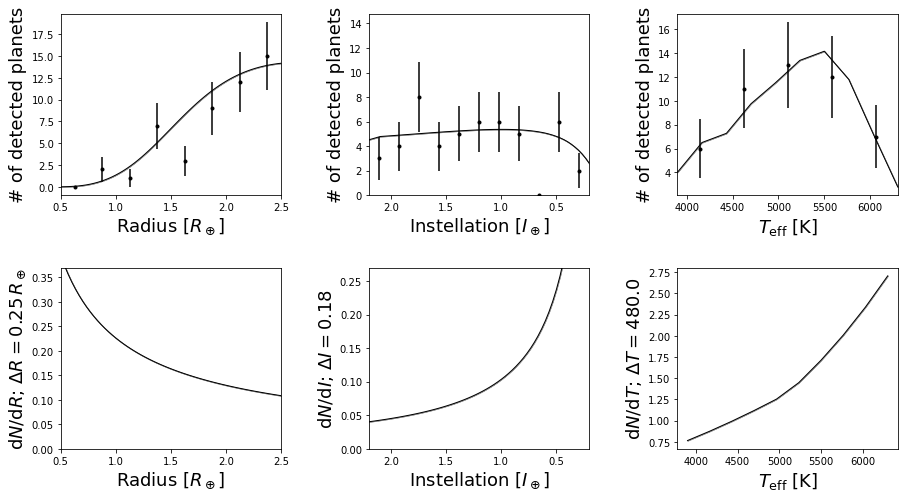

In [22]:
kois = allKois

    
# The ln-likelihood function given at the top of this post.
koi_insolation = np.array(kois.insolation)
koi_rps = np.array(kois.gaia_iso_prad)
koi_teffs = np.array(kois.teff)

theta_0 = model.initRateModel()
r = minimize(nll, theta_0, method="L-BFGS-B", bounds=model.getBounds(), 
             args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))
print(r.x)
fig = plot_results(r.x, cs, koi_rps, koi_insolation, koi_teffs, summedCompleteness, model, reversePeriod=True);



In [23]:
model.integrateXY(cs.periodRange, cs.rpRange, 5117., r.x, cs)

array([1.33048294])

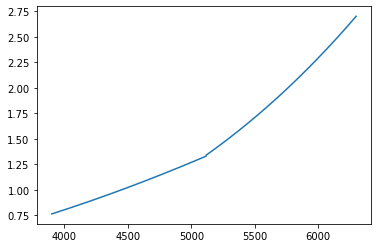

In [24]:
hcx = np.zeros(2400)
for i, t in enumerate(np.linspace(3900,3900+2400, 2400)):
    hcx[i] = model.integrateXY(cs.periodRange, cs.rpRange, t, r.x, cs)
plt.plot(np.linspace(3900,3900+2400, 2400), hcx)

In [25]:
sm = np.mean(stellarTargets[stellarTargets.teff>5200].teff)
sm

5748.845788987169

In [26]:
sd = np.std(stellarTargets.teff)
sd

507.92325997291454

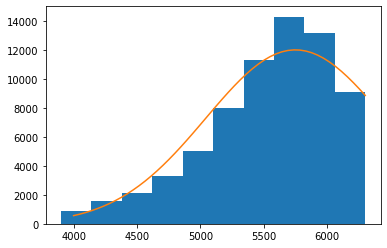

In [27]:
sd = 1000
plt.hist(stellarTargets.teff)
x = np.linspace(4000, 6300)
plt.plot(x, 12000*np.exp(-((x-sm)**2)/(sd**2)))


In [28]:
summedCompletenessTeff.shape

(61, 61, 10)

In [29]:
print("0.5-1.5 Re, Kopparapu Habitable Zone maxumum likelihood = " 
      + str(model.integrate([0.25,1.8], [0.5,1.5], [4800, 6300], r.x, cs)))
#       + str(ut.integrateRateModel([0.25,1.8], [0.5,1.5], r.x, model, cs)))
print("over whole domain maxumum likelihood = " 
      + str(model.integrate([0.2,2.2], [0.5,2.5], [3900, 6300], r.x, cs)))


0.5-1.5 Re, Kopparapu Habitable Zone maxumum likelihood = 0.9619208391999697
over whole domain maxumum likelihood = 1.4930658942134907


In [30]:

##################################################################


postName = outDir + "/occurenceRatePosteriors_noreliability.npy"
if path.exists(postName): 
    samples_noreliability = np.load(postName)
    ndim = samples_noreliability.shape[1]
else:
    ndim, nwalkers = len(r.x), nWalkers
#     pos = [model.initRateModel() + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8, 
             args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

    # Burn in.
    pos, _, _ = sampler.run_mcmc(pos, nBurnin)
    sampler.reset()

    # Production.
    start_time = time.time()
    pos, _, _ = sampler.run_mcmc(pos, nMcmc)
    print("--- %s seconds ---" % (time.time() - start_time))

    # kois.to_csv("occurenceRatePosteriors/selectedPcs_noreliability.csv")

    samples_noreliability = sampler.flatchain   
    np.save(postName, samples_noreliability)


--- 172.40828728675842 seconds ---


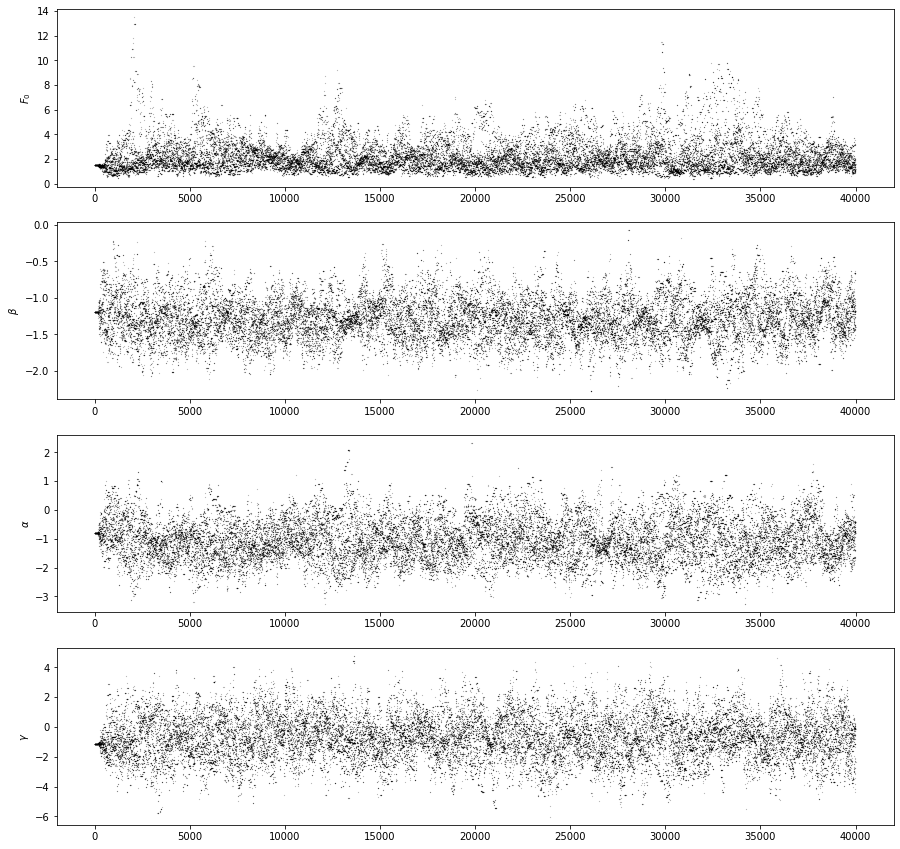

In [31]:
labels = model.getLabels()
fig, axes = plt.subplots(samples_noreliability.shape[1], 1, figsize=(15,15))
for i in range(samples_noreliability.shape[1]):
    ax = axes[i]
    ax.plot(samples_noreliability[:,i], 'k.', markersize=0.2, alpha=1)
    ax.set_ylabel(labels[i])


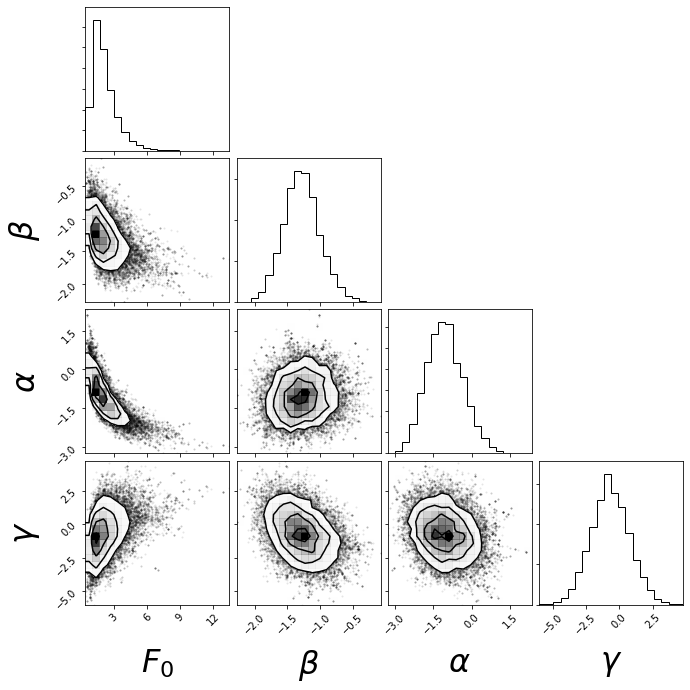

In [32]:
##################################################################
##################################################################

corner.corner(samples_noreliability, labels=model.getLabels(), label_kwargs = {"fontsize": 32});
plt.savefig(outDir + "/occPostNoReliability.pdf",bbox_inches='tight')

##################################################################




In [33]:
labels = model.getLabels()
for i in range(samples_noreliability.shape[1]):
    print(labels[i] + " = " + ut.printMedianAndErrorbars(samples_noreliability[:,i]))

$F_0$ = 1.906^{+1.297}_{-0.706}
$\beta$ = -1.293^{+0.280}_{-0.261}
$\alpha$ = -1.076^{+0.764}_{-0.688}
$\gamma$ = -0.716^{+1.456}_{-1.393}


In [34]:
# theta = model.initRateModel()
# theta = r.x
theta = np.median(samples_noreliability, 0)
m = model.rateModel(cs.period2D, cs.rp2D, meanTeff[0], cs.periodRange, cs.rpRange, cs.tempRange, theta)
m.shape

(61, 61)

In [35]:
theta.ndim

1

In [36]:
summedCompletenessTeff[:,:,0].shape

(61, 61)

In [37]:
[cs.vol[0,0,0], cs.vol2D[0,0]]

[0.2962962962962965, 0.0011111111111111107]

In [38]:
cs.vol[0,0,0]/cs.vol2D[0,0]

266.66666666666697

/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: No contour levels were found within the data range.
  after removing the cwd from sys.path.


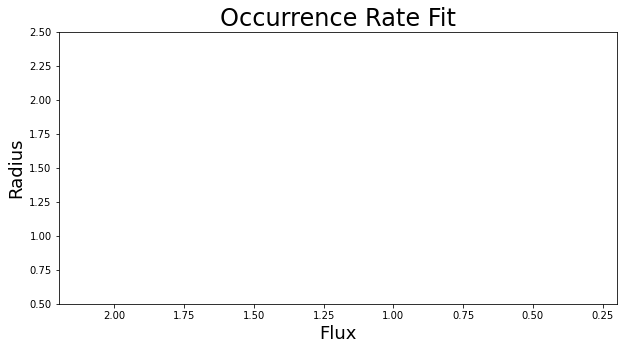

In [39]:
contourLevels = np.linspace(0,10,40)
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = model.rateModel(cs.period2D, cs.rp2D, meanTeff[0], cs.periodRange, cs.rpRange, cs.tempRange, theta)
CS = ax.contour(cs.period2D, cs.rp2D, 1000*rateGrid, contourLevels);
ax.clabel(CS, inline=1, fontsize=10);
xl = ax.get_xlim()
ax.set_xlim(xl[1], xl[0])
plt.xlabel("Flux", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: No contour levels were found within the data range.
  This is separate from the ipykernel package so we can avoid doing imports until


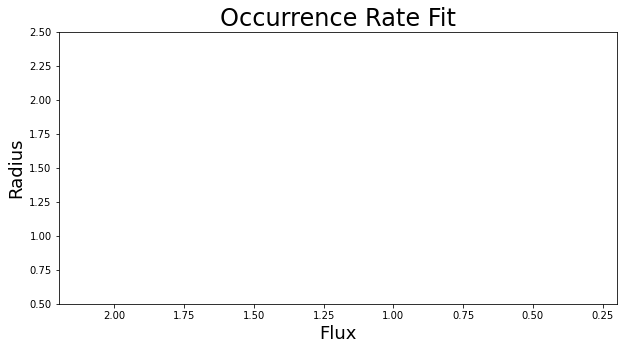

In [40]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = model.rateModel(cs.period2D, cs.rp2D, meanTeff[9], cs.periodRange, cs.rpRange, cs.tempRange, theta)
CS = ax.contour(cs.period2D, cs.rp2D, 1000*rateGrid, contourLevels);
ax.clabel(CS, inline=1, fontsize=10);
xl = ax.get_xlim()
ax.set_xlim(xl[1], xl[0])
plt.xlabel("Flux", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


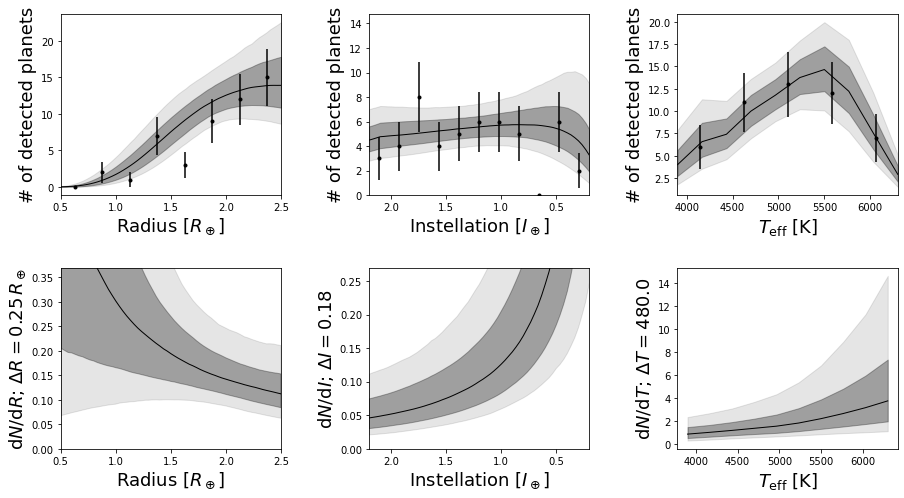

In [41]:
fig = plot_results(samples_noreliability[:-1:10,:], cs, koi_rps, koi_insolation, koi_teffs, 
                                               summedCompleteness, model, reversePeriod=True);
plt.savefig(outDir + "/occMargNoReliability.pdf",bbox_inches='tight')

##################################################################


In [42]:
ut.printMedianAndErrorbars(model.integrate([0.25,1.8], [0.5,1.5], [4800,6300], samples_noreliability, cs))


'1.314^{+1.297}_{-0.648}'

In [43]:
model.integrate(cs.periodRange, cs.rpRange, cs.tempRange, np.median(samples_noreliability, 0), cs)

1.9062972816671433

Compute an occurrence rate with reliability

In [44]:
nTrials = 400

koi_insolation_rel = []
koi_rps_rel = []
koi_teffs_rel = []
postName = outDir + "/occurenceRatePosteriors.npy"
postRelName = outDir + "/occurenceRatePosteriors"
if path.exists(postName): 
    allSamples = np.load(postName)
    koi_insolation_rel = np.load(postRelName + "_koi_insolation.npy", allow_pickle=True)
    koi_rps_rel = np.load(postRelName + "_koi_rps.npy", allow_pickle=True)
    koi_teffs_rel = np.load(postRelName + "_koi_teffs.npy", allow_pickle=True)
    
    ndim = allSamples.shape[1]
else:
    f = FloatProgress(min=0, max=nTrials)
    display(f)

    allKois = base_kois
    for mCount in range(nTrials):
        # randomly select kois

        koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
        # koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
        kois = allKois[koiSelect]
 
        ######### treating uncertainty
        koi_insolation = np.zeros(len(kois))
        plusErr = np.random.rand(len(kois)) > 0.5
        minusErr = plusErr == False
        koi_insolation[plusErr] = kois[plusErr].gaia_iso_insol + kois[plusErr].gaia_iso_insol_errp*np.random.randn(sum(plusErr))
        koi_insolation[minusErr] = kois[minusErr].gaia_iso_insol - kois[minusErr].gaia_iso_insol_errm*np.random.randn(sum(minusErr))  
        
        koi_rps = np.zeros(len(kois))
        plusErr = np.random.rand(len(kois)) > 0.5
        minusErr = plusErr == False
        koi_rps[plusErr] = kois[plusErr].gaia_iso_prad + kois[plusErr].gaia_iso_prad_errp*np.random.randn(sum(plusErr))
        koi_rps[minusErr] = kois[minusErr].gaia_iso_prad - kois[minusErr].gaia_iso_prad_errm*np.random.randn(sum(minusErr))  
        
        koi_teffs = np.zeros(len(kois))
        plusErr = np.random.rand(len(kois)) > 0.5
        minusErr = plusErr == False
        koi_teffs[plusErr] = kois[plusErr].teff + kois[plusErr].teff_err1*np.random.randn(sum(plusErr))
        koi_teffs[minusErr] = kois[minusErr].teff - kois[minusErr].teff_err2*np.random.randn(sum(minusErr))  

        m = (cs.periodRange[0] <= koi_insolation) & (koi_insolation <= cs.periodRange[1])
        m &= np.isfinite(koi_rps) & (cs.rpRange[0] <= koi_rps) & (koi_rps <= cs.rpRange[1])
#         m &= kois.koi_period <= 500
        m &= kois.koi_period <= 400
    
        koi_teffs = koi_teffs[m]
        koi_rps = koi_rps[m]
        koi_insolation = koi_insolation[m]

        koi_insolation_rel.append(koi_insolation)
        koi_rps_rel.append(koi_rps)
        koi_teffs_rel.append(koi_teffs)
#         print(str(len(koi_rps)) + " planets")

        theta_0 = model.initRateModel()
        r = minimize(nll, theta_0, method="L-BFGS-B", bounds=model.getBounds(), 
             args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

        ##################################################################


        ndim, nwalkers = len(r.x), 2*len(r.x)
        pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
             args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

        # Burn in.
        pos, _, _ = sampler.run_mcmc(pos, 400)
        sampler.reset()

        # Production.
        pos, _, _ = sampler.run_mcmc(pos, 2000)

        samples = sampler.flatchain   
        if mCount == 0:
            allSamples = samples
        else:
            allSamples = np.concatenate((allSamples, samples))

        f.value += 1
        
    np.save(postName, allSamples)
    np.save(postRelName + "_koi_insolation.npy", koi_insolation_rel)
    np.save(postRelName + "_koi_rps.npy", koi_rps_rel)
    np.save(postRelName + "_koi_teffs.npy", koi_teffs_rel)


FloatProgress(value=0.0, max=400.0)

/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater_equal
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal
/opt/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [45]:
# nTrials = 100

# postName = outDir + "/occurenceRatePosteriors.npy"
# if path.exists(postName): 
#     allSamples = np.load(postName)
#     ndim = allSamples.shape[1]
# else:
#     f = FloatProgress(min=0, max=nTrials)
#     display(f)

#     allKois = kois
#     for mCount in range(nTrials):
#         # randomly select kois

#         koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#         # koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
#         kois = allKois[koiSelect]
#     #    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
#     #    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
#     #          + " kois out of " + str(len(allKois)) + " after reliability cut")

#         koi_insolation = np.array(kois.insolation)
#         koi_rps = np.array(kois.gaia_iso_prad)
#         koi_teffs = np.array(kois.teff)
# #         print(str(len(koi_rps)) + " planets")

#         theta_0 = model.initRateModel()
#         r = minimize(nll, theta_0, method="L-BFGS-B", bounds=model.getBounds(), 
#              args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

#         ##################################################################


#         ndim, nwalkers = len(r.x), 2*len(r.x)
#         pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
#         sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
#              args=(cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

#         # Burn in.
#         pos, _, _ = sampler.run_mcmc(pos, 400)
#         sampler.reset()

#         # Production.
#         pos, _, _ = sampler.run_mcmc(pos, 2000)

#         samples = sampler.flatchain   
#         if mCount == 0:
#             allSamples = samples
#         else:
#             allSamples = np.concatenate((allSamples, samples))

#         f.value += 1
        
#     np.save(postName, allSamples)



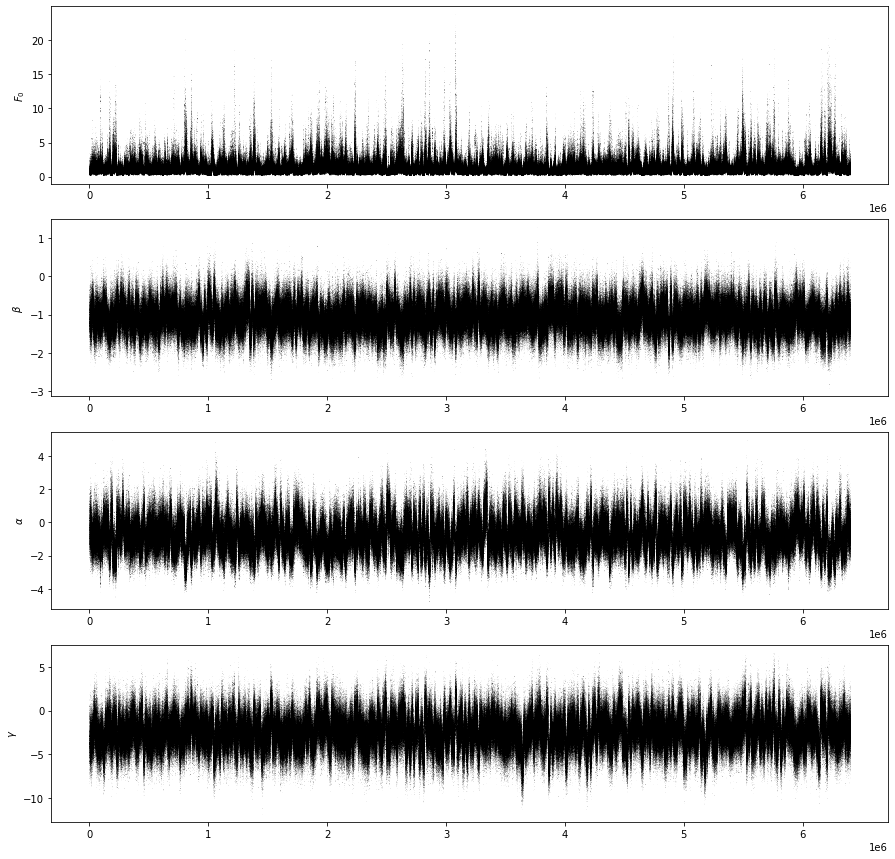

In [46]:
labels = model.getLabels()
fig, axes = plt.subplots(allSamples.shape[1], 1, figsize=(15,15))
for i in range(allSamples.shape[1]):
    ax = axes[i]
    ax.plot(allSamples[:,i], 'k.', markersize=0.2, alpha=0.1)
    ax.set_ylabel(labels[i])


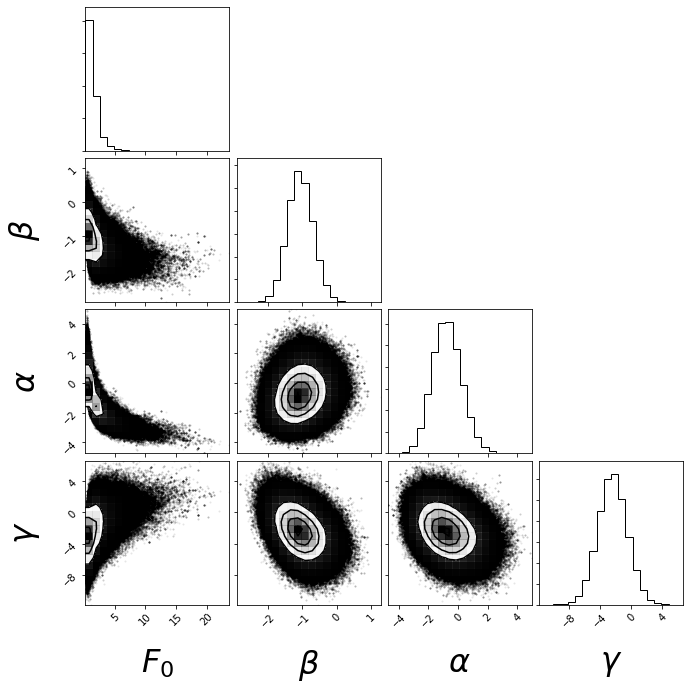

In [47]:
corner.corner(allSamples, labels=model.getLabels(), label_kwargs = {"fontsize": 32});
plt.savefig(outDir + "/occPostReliability.pdf",bbox_inches='tight')




In [48]:
modelLabels = model.getLabels()
for i in range(0,ndim):
    print("MCMC no reliability " + modelLabels[i] + "=" + ut.printMedianAndErrorbars(samples_noreliability[:,i]))
for i in range(0,ndim):
    print("MCMC with reliability " + modelLabels[i] + "=" + ut.printMedianAndErrorbars(allSamples[:,i]))


MCMC no reliability $F_0$=1.906^{+1.297}_{-0.706}
MCMC no reliability $\beta$=-1.293^{+0.280}_{-0.261}
MCMC no reliability $\alpha$=-1.076^{+0.764}_{-0.688}
MCMC no reliability $\gamma$=-0.716^{+1.456}_{-1.393}
MCMC with reliability $F_0$=1.088^{+0.996}_{-0.452}
MCMC with reliability $\beta$=-1.073^{+0.377}_{-0.360}
MCMC with reliability $\alpha$=-0.782^{+1.016}_{-0.947}
MCMC with reliability $\gamma$=-2.413^{+1.849}_{-1.819}


In [49]:
# # make planet popoulation resample for reliability
# koi_insolation_rel = []
# koi_rps_rel = []
# koi_teffs_rel = []
# for mCount in range(nTrials):
#     # randomly select kois

#     koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
#     # koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
#     kois = allKois[koiSelect]
# #    kois.to_csv("occurenceRatePosteriors/selectedPcs" + str  (mCount) + ".csv")
# #    print(str(mCount) + " of " + str(nTrials) + ", selected " + str(len(kois)) 
# #          + " kois out of " + str(len(allKois)) + " after reliability cut")

#     koi_insolation_rel.append(np.array(kois.insolation))
#     koi_rps_rel.append(np.array(kois.gaia_iso_prad))
#     koi_teffs_rel.append(np.array(kois.teff))

# isinstance(koi_insolation_rel, list)

In [50]:
koi_rps_rel[3].size

35

In [51]:
isinstance(koi_rps_rel, list)

True

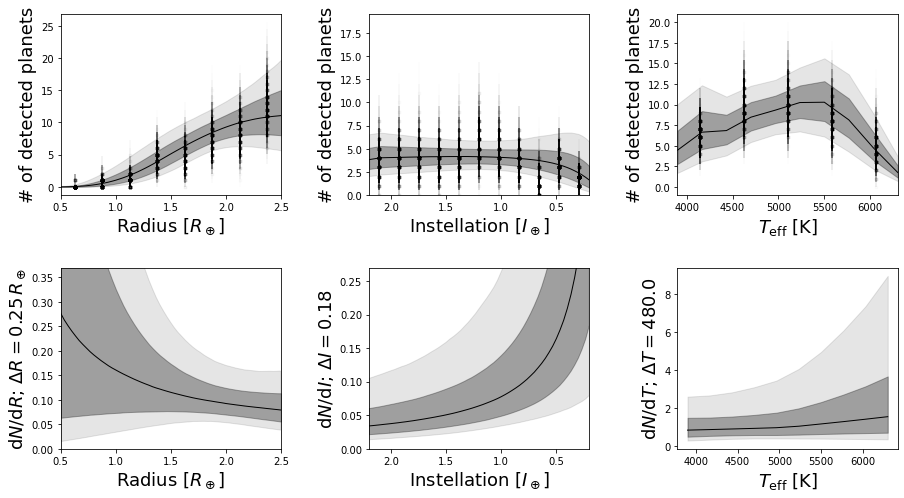

In [52]:
fig = plot_results(allSamples[:-1:nTrials,:], cs, koi_rps_rel, koi_insolation_rel, koi_teffs_rel,
                                   summedCompleteness, model, reversePeriod=True)
plt.savefig(outDir + "/occMargReliability.png",bbox_inches='tight')


In [53]:
KHZDist = model.integrate([0.25,1.8], [0.5,1.5], [4800,6300], allSamples[:-1:10,:], cs)
KHZDist_nr = model.integrate([0.25,1.8], [0.5,1.5], [4800,6300], samples_noreliability, cs)


In [54]:
len(koi_insolation_rel[1])

44

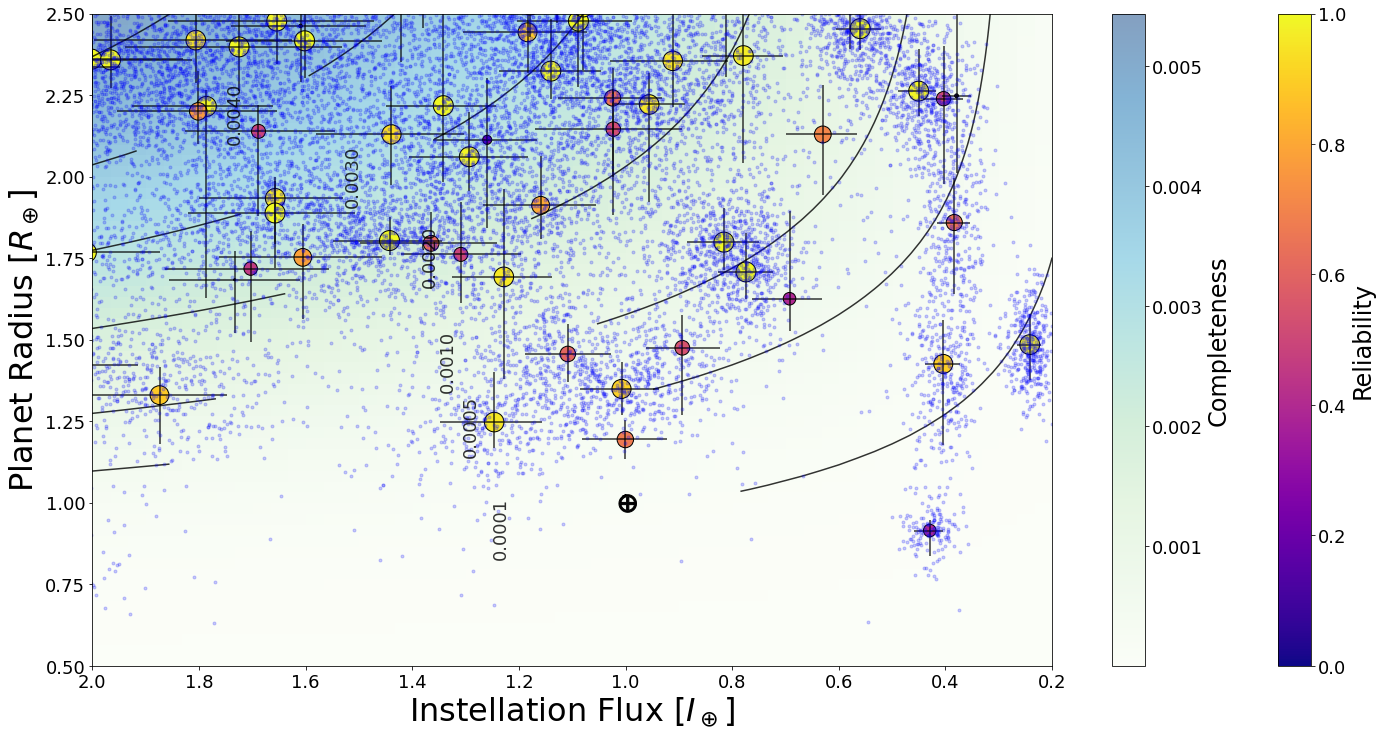

In [55]:
# contourLevels = np.arange(1e-2, 1, 5e-2)
contourLevels = np.arange(1e-3, 1e-2, 1e-3)
contourLevels = np.insert(contourLevels, 0, [1e-4, 5e-4])

fig, ax = plt.subplots(figsize=(25,12));

pc = plt.pcolor(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, cmap=light_BuGn)
c = plt.contour(cs.period2D, cs.rp2D, summedCompleteness / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
scf = plt.scatter(allKois.insolation, allKois.gaia_iso_prad, cmap="plasma", 
               c=allKois.totalReliability, edgecolors='k', s=400*allKois.totalReliability, alpha = 1.0)
ax.errorbar(allKois.gaia_iso_insol, allKois.gaia_iso_prad, 
            xerr = [allKois.gaia_iso_insol_errm, allKois.gaia_iso_insol_errp],
            yerr = [allKois.gaia_iso_prad_errm, allKois.gaia_iso_prad_errp],
            fmt="none", ecolor="k", alpha = 0.8, marker = None);

cbh = plt.colorbar(scf, pad=-0.01);
cbh.ax.set_ylabel("Reliability", fontsize = 24);
cbh.ax.tick_params(labelsize=18)

cbh = plt.colorbar(pc);
cbh.ax.set_ylabel("Completeness", fontsize = 24);
cbh.ax.tick_params(labelsize=18)

plt.scatter(1, 1, marker="$\oplus$", c='k', s=400, alpha = 1.0, zorder=100)

for i in range(len(koi_insolation_rel)):
    plt.plot(koi_insolation_rel[i], koi_rps_rel[i], 'b.', alpha=0.2)

#c = plt.contour(cs.period2D, cs.rp2D, numCompVe / kiclist.size,
#               colors="k", alpha=0.8)
plt.ylim(0.5, 2.5)
xlim = plt.xlim();
plt.xlim(xlim[1], xlim[0]);
# plt.xlim(50, 400)
plt.clabel(c, fontsize=18, inline=1, fmt="%.4f")
# plt.title("DR25 PC Average detection*vetting efficiency", fontsize = 18)
plt.tick_params(labelsize = 18)
plt.xlabel('Instellation Flux [$I_\oplus$]', fontsize = 32);
plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 32);

plt.xlim(2.0,0.2)

plt.savefig(outDir + "/summedCompletenessInsol.png",bbox_inches='tight')




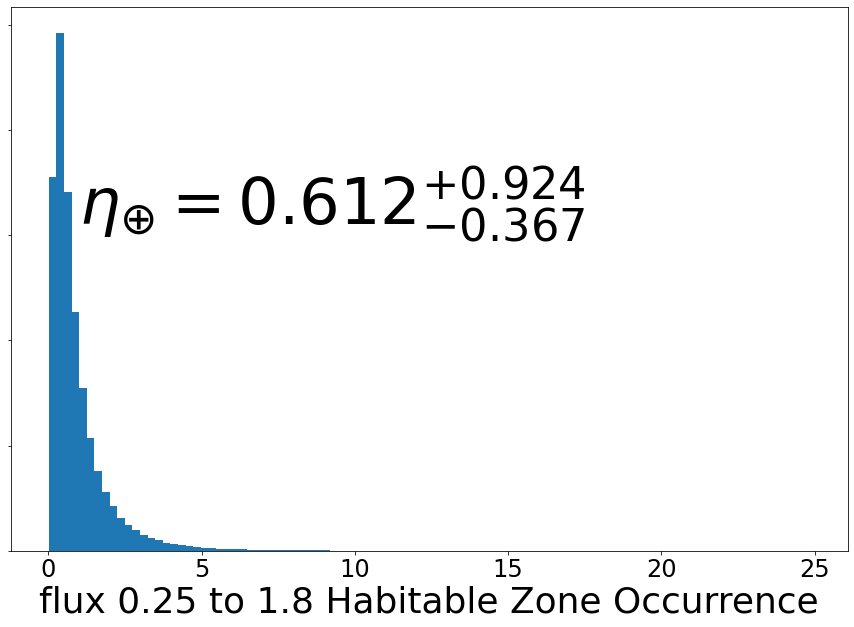

In [56]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(KHZDist, 100, histtype="stepfilled", density=True);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(1.0, 0.6*plt.ylim()[1], r"$\eta_{\oplus} = " + ut.printMedianAndErrorbars(KHZDist) + "$", fontSize = 64)
plt.xlabel("flux 0.25 to 1.8 Habitable Zone Occurrence", fontSize = 36);
plt.savefig(outDir + "/KHZDist.pdf",bbox_inches='tight')
# plt.title("Kopparapu Habitable Zone Distribution, 0.5-1.5 $R_\oplus$", fontsize=18);


In [57]:
print("0.5-1.5 Re, Kopparapu Habitable Zone median = " 
      + str(model.integrate([0.25,1.8], [0.5,1.5], [4800,6300], np.median(allSamples, 0), cs)))

print("0.5-1.5 Re, Kopparapu Habitable Zone without reliability median = " 
      + str(model.integrate([0.25,1.8], [0.5,1.5], [4800,6300], np.median(samples_noreliability, 0), cs)))

print("0.5-1.5 Re, Kopparapu Habitable Zone = " + ut.printMedianAndErrorbars(KHZDist))
print("0.5-1.5 Re, Kopparapu Habitable Zone without reliability = " + ut.printMedianAndErrorbars(KHZDist_nr))


0.5-1.5 Re, Kopparapu Habitable Zone median = 0.639881738899044
0.5-1.5 Re, Kopparapu Habitable Zone without reliability median = 1.344860774081823
0.5-1.5 Re, Kopparapu Habitable Zone = 0.612^{+0.924}_{-0.367}
0.5-1.5 Re, Kopparapu Habitable Zone without reliability = 1.314^{+1.297}_{-0.648}


In [58]:
print("1.5-2.5 Re, Kopparapu Habitable Zone median = " 
      + str(model.integrate([0.25,1.8], [1.5,2.5], [4800,6300], np.median(allSamples, 0), cs)))

print("1.5-2.5 Re, Kopparapu Habitable Zone without reliability median = " 
      + str(model.integrate([0.25,1.8], [1.5,2.5], [4800,6300], np.median(samples_noreliability, 0), cs)))

KHZDist2 = model.integrate([0.25,1.8], [1.5,2.5], [4800,6300], allSamples[:-1:10,:], cs)
KHZDist2_nr = model.integrate([0.25,1.8], [1.5,2.5], [4800,6300], samples_noreliability, cs)

print("1.5-2.5 Re, Kopparapu Habitable Zone = " + ut.printMedianAndErrorbars(KHZDist2))
print("1.5-2.5 Re, Kopparapu Habitable Zone without reliability = " + ut.printMedianAndErrorbars(KHZDist2_nr))


1.5-2.5 Re, Kopparapu Habitable Zone median = 0.353795734702044
1.5-2.5 Re, Kopparapu Habitable Zone without reliability median = 0.588173310884807
1.5-2.5 Re, Kopparapu Habitable Zone = 0.338^{+0.152}_{-0.105}
1.5-2.5 Re, Kopparapu Habitable Zone without reliability = 0.578^{+0.198}_{-0.146}


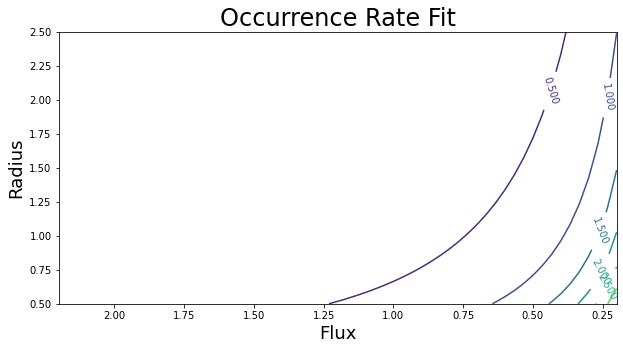

In [59]:
fig, ax = plt.subplots(figsize=(10,5));
rateGrid = model.rateModel(cs.period2D, cs.rp2D, meanTeff[9], cs.periodRange, cs.rpRange, cs.tempRange, np.median(allSamples, 0))
CS = ax.contour(cs.period2D, cs.rp2D, rateGrid);
ax.clabel(CS, inline=1, fontsize=10);
xl = ax.get_xlim()
ax.set_xlim(xl[1], xl[0])
plt.xlabel("Flux", fontsize = 18);
plt.ylabel("Radius", fontsize = 18);
plt.title("Occurrence Rate Fit", fontsize = 24);


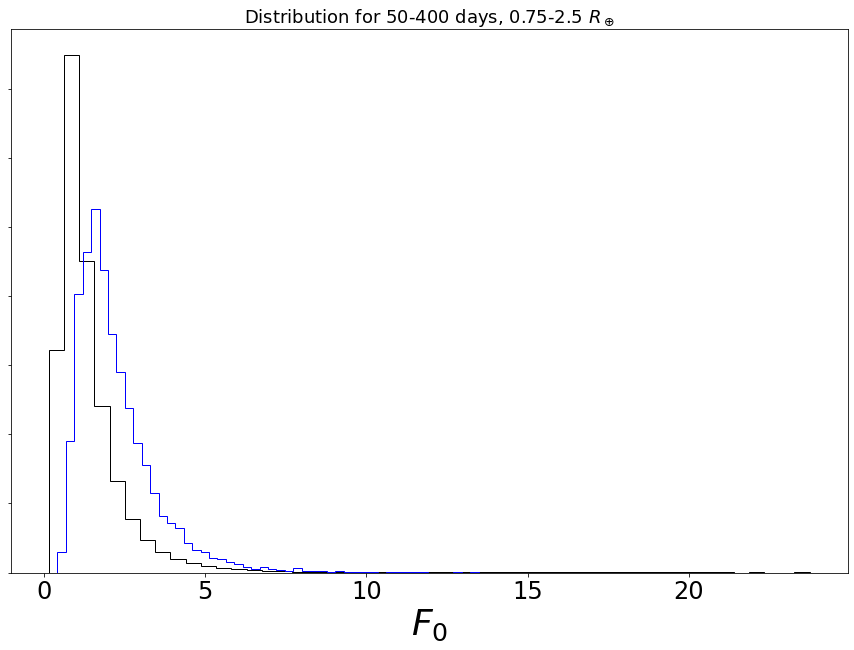

In [60]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
plt.hist(allSamples[:,0], 50, histtype="step", color="k", density=True);
plt.hist(samples_noreliability[:,0], 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.xlabel(r"$F_0$", fontSize = 36);
plt.savefig(outDir + "/f0Dist.pdf",bbox_inches='tight')
plt.title("Distribution for 50-400 days, 0.75-2.5 $R_\oplus$", fontsize=18);



In [61]:
len(stellarTargets)

68885

In [62]:
def hzOccRate2D(teffRange, rpRange, samples, model, cs, nSamples=None, hzType = "optimistic"):
    teff = np.linspace(teffRange[0], teffRange[1], np.round(teffRange[1]-teffRange[0]))
    hz = rm3D.getHzFlux(teff, hzType)
    f = FloatProgress(min=0, max=hz.shape[1])
    display(f)
    if samples.ndim == 1:
        hzOptOccRate = np.zeros(hz.shape[1])
        for s in range(hz.shape[1]):        
            hzOptOccRate[s] = model.integrateXY([hz[1,s], hz[0,s]], rpRange, teff[s], samples, cs)
            f.value += 1
    else:
        hzOptOccRate = np.zeros((hz.shape[1], nSamples))
        for s in range(hz.shape[1]):        
            if nSamples != None:
                sampleIndex = np.floor(samples.shape[0]*np.random.rand(nSamples)).astype(int)
                useSamples = samples[sampleIndex,:]
            else:
                useSamples = samples
            hzOptOccRate[s,:] = model.integrateXY([hz[1,s], hz[0,s]], rpRange, teff[s], useSamples, cs)
            f.value += 1
        
    return hzOptOccRate, teff


# def hzOccRate2D(teffRange, rpRange, samples, model, cs, nSamples=None):
#     teff = np.linspace(teffRange[0], teffRange[1], np.round(teffRange[1]-teffRange[0]))
#     hz = rm3D.getHzFlux(teff)
#     f = FloatProgress(min=0, max=hz.shape[1])
#     display(f)
#     if samples.ndim == 1:
#         hzOptOccRate = np.zeros(hz.shape[1]-1)
#         for s in range(hz.shape[1]-1):        
#             hzOptOccRate[s] = len(teff)*model.integrate([hz[1,s], hz[0,s]], rpRange, [teff[s],teff[s+1]], samples, cs)
#             f.value += 1
#     else:
#         hzOptOccRate = np.zeros((hz.shape[1]-1, nSamples))
#         for s in range(hz.shape[1]-1):        
#             if nSamples != None:
#                 sampleIndex = np.floor(samples.shape[0]*np.random.rand(nSamples)).astype(int)
#                 useSamples = samples[sampleIndex,:]
#             else:
#                 useSamples = samples
#             hzOptOccRate[s,:] = model.integrate([hz[1,s], hz[0,s]], rpRange, [teff[s],teff[s+1]], useSamples, cs)
# #             hzOptOccRate[s,:] = ((cs.tempRange[1]-cs.tempRange[0])/(teff[s+1]-teff[s])) \
# #                 *model.integrate([hz[1,s], hz[0,s]], rpRange, [teff[s],teff[s+1]], useSamples, cs)
#             f.value += 1
        
#     return hzOptOccRate, teff

In [63]:
print(np.median(allSamples,0))
model.integrateXY(cs.periodRange, cs.rpRange, 5778, allSamples, cs)

[ 1.08777333 -1.07288993 -0.78243857 -2.41334323]


array([0.73281067, 1.31016632, 1.1613708 , ..., 1.39457721, 1.25011055,
       0.81153554])

In [64]:
model.integrateXY(cs.periodRange, cs.rpRange, 5778, np.median(samples_noreliability, 0), cs)

array([2.66276358])

In [65]:
hzOptimisticDist2, hzTeff = rm3D.hzOccRate2D([4800,6300], [0.5,1.5], allSamples, model, cs, nSamples = 10000, hzType="optimistic")
hzConservativeDist2, hzTeff = rm3D.hzOccRate2D([4800,6300], [0.5,1.5], allSamples, model, cs, nSamples = 10000, hzType="conservative")
# hzOptimisticDist2, hzTeff = hzOccRate2D([4800,6300], [0.5,1.5], samples_noreliability, model, cs, nSamples = 1000, hzType="optimistic")
# hzOptimisticDist2 = hzOccRate2D([4800,6300], [0.5,2.5], allSamples, model, cs, nSamples = 100)
# hzOptimisticDist2, hzTeff = hzOccRate2D([4800,6300], [0.5,1.5], np.median(samples_noreliability, 0), model, cs, nSamples = 100)

FloatProgress(value=0.0, max=1500.0)

FloatProgress(value=0.0, max=1500.0)

In [66]:
print("optimistic HZ: " + ut.printMedianAndErrorbars(hzOptimisticDist2.flatten(), precision = 2))
print("conservative HZ: " + ut.printMedianAndErrorbars(hzConservativeDist2.flatten(), precision = 2))

optimistic HZ: 0.52^{+0.78}_{-0.31}
conservative HZ: 0.35^{+0.54}_{-0.21}


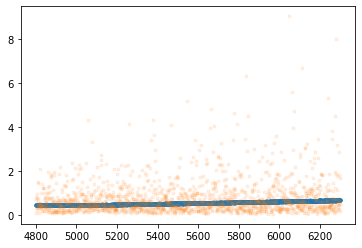

In [67]:
plt.plot(hzTeff, np.median(hzOptimisticDist2, axis=1), '.');
plt.plot(hzTeff, hzOptimisticDist2[:,0], '.', alpha=0.1);

(15000000,)


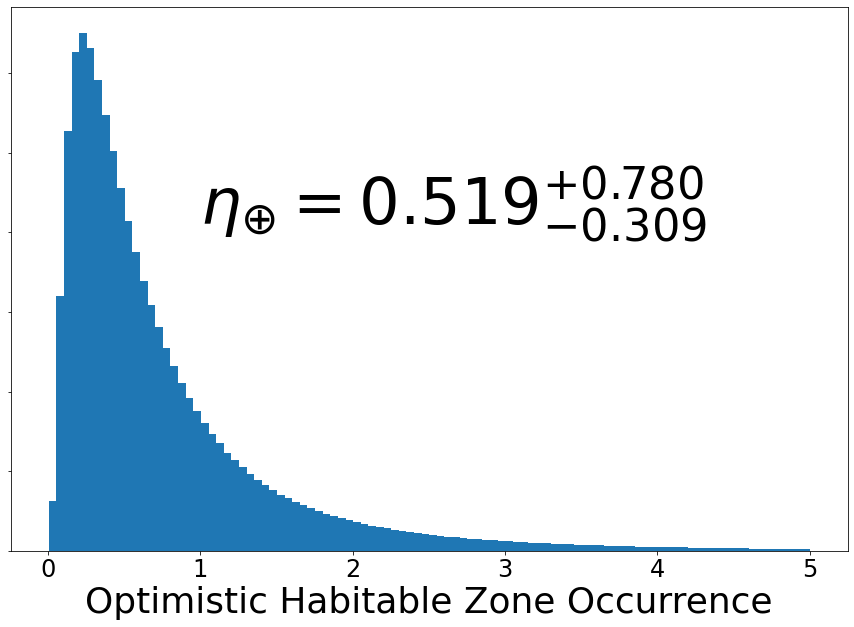

In [68]:
plt.figure(figsize=(15,10));
greyLevel = "0.7"
dist = hzOptimisticDist2.flatten()
print(dist.shape)
plt.hist(dist[np.abs(dist)<5], 100, histtype="stepfilled", density=True);
# plt.hist(KHZDist_nr, 50, histtype="step", color="b", density=True);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.text(1.0, 0.6*plt.ylim()[1], r"$\eta_{\oplus} = " + ut.printMedianAndErrorbars(dist) + "$", fontSize = 64)
plt.xlabel("Optimistic Habitable Zone Occurrence", fontSize = 36);
# plt.xlim(0,5)
# plt.savefig(outDir + "/optimisticKHZDist.pdf",bbox_inches='tight')
# plt.title("Kopparapu Habitable Zone Distribution, 0.5-1.5 $R_\oplus$", fontsize=18);


In [69]:
avg = model.integrate([0.35,1.6], [0.5,1.5], [4800,6300], allSamples, cs)
ut.printMedianAndErrorbars(avg)

'0.467^{+0.685}_{-0.278}'

In [70]:
avg = model.integrate(cs.periodRange, cs.rpRange, [3900,6300], allSamples, cs)
ut.printMedianAndErrorbars(avg)

'1.088^{+0.996}_{-0.452}'

In [71]:
model.integrateXY([0.25,1.7], [0.5,1.5], 5778, np.median(allSamples,0), cs)

array([0.66843221])

0.43975276723713863
[0.33046179257633085, 0.6277038995972127]


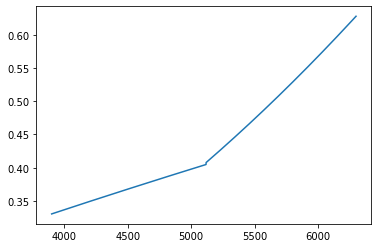

In [72]:
tRange = [3900,6300]
theta = np.median(allSamples,0)
print(model.integrate([0.35,1.6], [0.5,1.5], tRange, theta, cs))
hzt = np.linspace(tRange[0], tRange[1], tRange[1]-tRange[0]+1)
hzavg = np.zeros(hzt.shape)
for i,t in enumerate(hzt):
    hzavg[i] = model.integrateXY([0.35,1.6], [0.5,1.5], t, theta, cs)
print([np.min(hzavg), np.max(hzavg)])
plt.plot(hzt, hzavg);


In [73]:
fitTheta = np.median(allSamples,0)
medianAic = 2*len(fitTheta) \
        - 2*(lnlike(fitTheta, cs, koi_insolation, koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))
print(medianAic)

243.4409387549889


In [74]:
filename = outDir + "/aicDist.npy"
if path.exists(filename): 
    aicDist = np.load(filename)
else:
    nTrials = 100
    sampleSet = allSamples[:-1:1000,:]
    aicDist = np.zeros((sampleSet.shape[0], nTrials))

    f = FloatProgress(min=0, max=nTrials)
    display(f)

    for mCount in range(nTrials):
        # randomly select kois

        koiSelect = (np.random.rand(len(allKois)) < allKois.totalReliability)
        # koiSelect = (np.random.rand(len(allKois)) < allKois.reliability)
        kois = allKois[koiSelect]

        koi_insolation = np.array(kois.insolation)
        koi_rps = np.array(kois.gaia_iso_prad)
        koi_teffs = np.array(kois.teff)

        for s in range(aicDist.shape[0]):
            aicDist[s, mCount] = 2*sampleSet.shape[1] - 2*(lnlike(sampleSet[s,:], cs, koi_insolation, 
                            koi_rps, koi_teffs, summedCompletenessTeff, meanTeff, model))

        f.value += 1
        
    np.save(filename, aicDist)
    


FloatProgress(value=0.0)

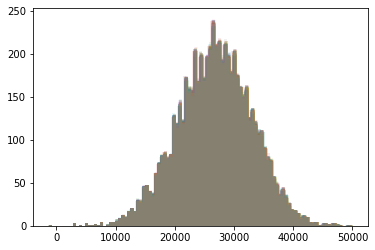

In [75]:
for i in range(aicDist.shape[1]):
    plt.hist(aicDist[:,i], 100, alpha = 0.1);


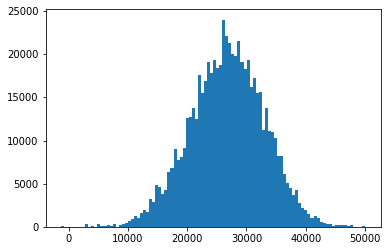

In [76]:
plt.hist(aicDist.flatten(), 100);


In [77]:
np.median(aicDist.flatten())

26841.432213144784

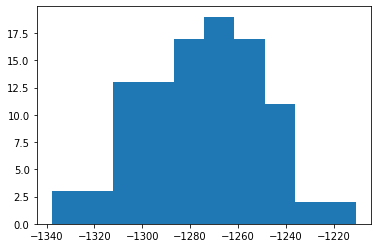

In [78]:
plt.hist(np.min(aicDist, 0), 10);

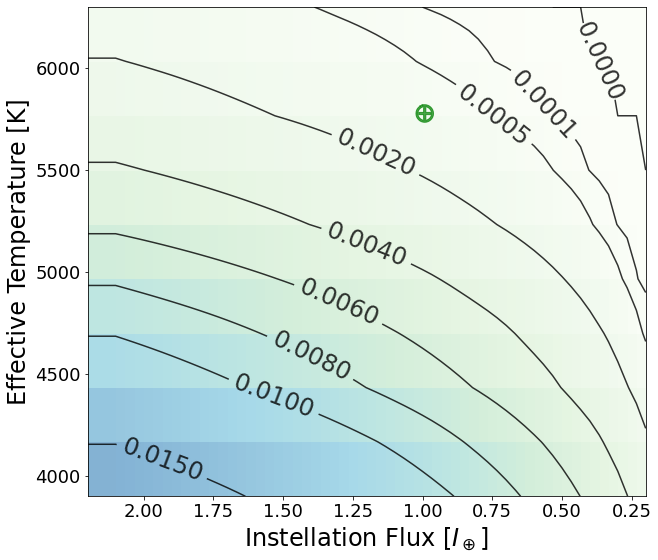

In [79]:
contourLevels = [0,  1e-4, 5e-4, 2e-3, 4e-3, 6e-3, 8e-3, 1e-2, 1.5e-2]

fig, ax = plt.subplots(figsize=(10,9));

sc = 0.5 * (summedCompletenessTeff[:, 1:, :] + summedCompletenessTeff[:, :-1, :])
scs = np.sum(sc * np.diff(cs.rp1D)[None,:, None], axis=1)
scs = scs*(len(stellarTargets)/nstars)[None,:]

pc = plt.pcolor(cs.period2DTemp, cs.temp2D, scs / kiclist.size, cmap=light_BuGn, vmin=0, vmax=0.02)
c = plt.contour(cs.period2DTemp, cs.temp2D, scs / kiclist.size, contourLevels,
               colors="k", alpha=0.8)
plt.scatter(1, 5778, marker="$\oplus$", c='g', s=400, alpha = 0.7, zorder=100)
xl = plt.xlim()
plt.xlim(xl[1], xl[0])

plt.clabel(c, fontsize=24, inline=1, fmt="%.4f")
# cbh = plt.colorbar(pc);
# cbh.ax.set_ylabel("Average Completeness", fontsize = 24);
# cbh.ax.tick_params(labelsize=24)
plt.tick_params(labelsize = 18)
plt.xlabel('Instellation Flux [$I_\oplus$]', fontsize = 24);
# plt.ylabel("Planet Radius [$R_\oplus$]", fontsize = 24);
plt.ylabel("Effective Temperature [K]", fontsize = 24);
plt.savefig(outDir + "/completenessFluxT.png",bbox_inches='tight')



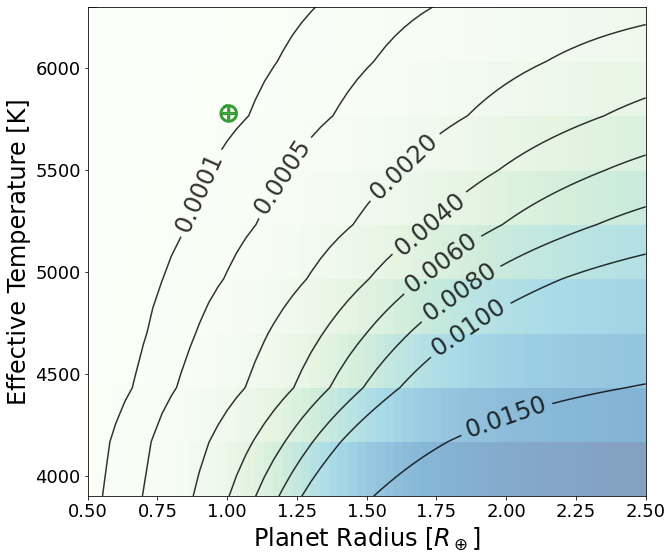

In [80]:

fig, ax = plt.subplots(figsize=(10,9));

sc = 0.5 * (summedCompletenessTeff[1:, :, :] + summedCompletenessTeff[:-1, :, :])
scs = np.sum(sc * np.diff(cs.rp1D)[:,None, None], axis=0)
scs = scs*(len(stellarTargets)/nstars)[None,:]

pc = plt.pcolor(cs.radius2DTemp, cs.temp2D, scs / kiclist.size, cmap=light_BuGn, vmin=0, vmax=0.02)
c = plt.contour(cs.radius2DTemp, cs.temp2D, scs / kiclist.size, contourLevels,
               colors="k", alpha=0.8)

plt.scatter(1, 5778, marker="$\oplus$", c='g', s=400, alpha = 0.7, zorder=100)

plt.clabel(c, fontsize=24, inline=1, fmt="%.4f")
# cbh = plt.colorbar(pc);
# cbh.ax.set_ylabel("Average Completeness", fontsize = 24);
# cbh.ax.tick_params(labelsize=24)
plt.tick_params(labelsize = 18)
plt.xlabel("Planet Radius [$R_\oplus$]", fontsize = 24);
plt.ylabel("Effective Temperature [K]", fontsize = 24);
plt.savefig(outDir + "/completenessRadT.png",bbox_inches='tight')




In [81]:
outDir

'computeOccurrencefixedTeff_dr25_hab2_triplePowerLawTeffAvg_extrap_zero_zero400_uncertainty_out'

In [82]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [83]:
%%bash -s  "$outDir"
jupyter nbconvert --to html computeOccurrencefixedTeff_uncertainty.ipynb
mv computeOccurrencefixedTeff_uncertainty.html htmlArchive/$1.html

[NbConvertApp] Converting notebook computeOccurrencefixedTeff_uncertainty.ipynb to html
[NbConvertApp] Writing 3605176 bytes to computeOccurrencefixedTeff_uncertainty.html


In [84]:
allSamples.shape

(6400000, 4)

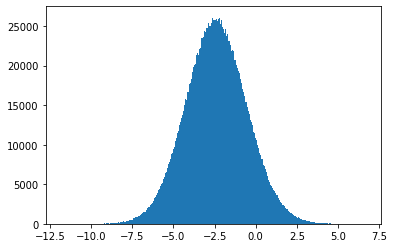

In [85]:
g = allSamples[:,3]
plt.hist(g, 1000);

In [86]:
np.sum(g>=0)/len(g)

0.09814328125